# Modèle EOLES

Traduction en python du modèle EOLES créé par Philippe Quirion.

### Imports

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

### Définition des variables

In [2]:
# Months 
m = ["jan","feb", "mar","apr","jun","jul","aug","sep","oct","nov","dec"]
# Technologies 
tec = ["offshore","onshore","pv","river","lake","biogas","gas","phs","battery","methanation"]
# Power plants
gen = ["offshore","onshore","pv","river","lake","biogas","gas"]
# Variable tec
vre = ["offshore","onshore","pv"]
# Non combustible generation tec
ncomb = ["offshore","onshore","pv","river","lake","phs","battery"]
# Combustible generation tec
comb = ["biogas","methanation"]
# Storage technologies
stor = ["phs","battery","methanation"]
# Technologies for upward FRR 
frr = ["lake","phs","battery","gas"]

### Input Data

Import des données. 

In [3]:
# profil des VRE par heure (éolien + PV)
load_factor = pd.read_csv("inputs/vre_profiles2006.csv", header = None, names = ["vre","h","load_factor"])

# demande d'électricité en 2050 par heure 
demand_2050 = pd.read_csv("inputs/demand2050_ademe.csv", header = None, names = ["h","demand_2050"])

# profil des lacs par mois
lake_inflows = pd.read_csv("inputs/lake_inflows.csv", header = None , names = ["m", "lake_inflows"])

# profil des rivières par heure
gene_river = pd.read_csv("inputs/run_of_river.csv", header = None , names = ["h","gene_river"])

# additional FRR requirement for variable renewable energies because of forecast errors
epsilon = pd.read_csv("inputs/reserve_requirements.csv", header = None, names = ["vre","epsilon"])

# capacités existantes pour les technologies en GW
capa_ex = pd.read_csv("inputs/existing_capas.csv", header = None, names=["tec","capa_ex"])

# Capacité maximum par technologies en GW 
capa_max = pd.read_csv("inputs/max_capas.csv", header = None, names=["tec","capa_max"])

# annualized power capex cost in M€/GW/year 
capex = pd.read_csv("inputs/annuities.csv", header = None, names = ["tec", "capex"])

# annualized energy capex cost of storage technologies in M€/GWh/year'
capex_en = pd.read_csv("inputs/str_annuities.csv", header = None, names = ["str","capex"])

# annualized fixed operation and maintenance costs M€/GW/year
fOM = pd.read_csv("inputs/fO&M.csv", header = None, names=["tec", "fOM"])

# Variable operation and maintenance costs in M€/GWh
vOM = pd.read_csv("inputs/vO&M.csv", header = None, names = ["tec", "vOM"])

### Parameters

In [4]:
# charging related annuity of storage in M€/GW/year : PHS, battery, methanation 
s_capex = [0,0,84.16086]
# charging related fOM of storage in M€/GW/year
s_opex = [0,0,59.25]
# charging efifciency of storage technologies
eta_in = [0.95,0.9,0.59]
# discharging efficiency of storage technolgoies
eta_out = [0.9, 0.95, 0.45]
# pumping capacity in GW
pump_cap = 9.3
# maximum volume of energy can be stored in PHS reservoir in TWh
max_phs = 0.18
# maxium energy can be generated by biogas in TWh
max_biogas = 15
# uncertainty coefficient for hourly demand
load_uncertainty = 0.01
# load variation factor
delta = 0.1
# yearly fixed cost of each tec in M€/GW/year
fixed_costs = pd.DataFrame({'tec' : tec, 'fixed_costs' : capex.capex + fOM.fOM})


### Import et affichage des résultats

In [5]:
scenarios = pd.read_csv("outputs/scenarios.csv", index_col="scen")
cost_decomposition = pd.read_csv("outputs/cost decomposition for all scenarios.csv", index_col="scen")

In [6]:
#scénario choisi 
scen = 157 
list(scenarios.iloc[scen][5:])

['central', 'central', 'central', 'central', 'central']

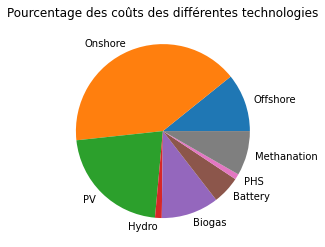

In [7]:
plt.figure()
plt.pie(list(map(lambda x: float(x[:-1]),list(cost_decomposition.iloc[scen]))), labels = ["Offshore","Onshore","PV","Hydro","Biogas","Battery","PHS","Methanation"])
plt.title("Pourcentage des coûts des différentes technologies")
plt.show()

In [8]:
scen2006 = pd.read_csv("outputs/real CF after internalization of LC/2006_LC_internalized.csv", index_col = "hour")

In [9]:
scen2006[4:5]

,offshore,onshore,pv,river,lake,biogas,gas,phs,battery,methanation,demand,Pump,ElecStr,CH4,Bat_SOC,PHS_SOC,CH4_SOC,elec_price,gas_price
hour,,,,,,,,,,,,,,,,,,,
4,2.17,42.95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.16,-9.3,0.0,-7.66,38.37,111.06,1831.46,0.0,0.0


In [12]:
import panel as pn 
import numpy as np 
import pandas as pd
from matplotlib.figure import Figure
import matplotlib.pyplot as plt
from ipywidgets import interactive, interact_manual
from matplotlib.backends.backend_agg import FigureCanvas
import ipywidgets as widgets
#%matplotlib inline
pn.extension()

In [13]:
# Dashboard
def show(week):
    plt.figure(figsize=(10,5))
    h  = 168*(week-1)+np.arange(1,169)
    
    ymin, ymax = -45,110

    # Stockage - Pump -> Hydro Pump / ElecStr -> electricity storage ie battery charging / CH4 -> methanation charging 
    plt.fill_between(h, scen2006.Pump[h] + scen2006.ElecStr[h] + scen2006.CH4[h], label = "Methanation charging",color="#7f6000")
    plt.fill_between(h, scen2006.Pump[h] + scen2006.ElecStr[h], label = "Battery charging",color="#7030a0")
    plt.fill_between(h, scen2006.Pump[h], label = "Pump",color="#bdd7ee")

    # Production
    plt.fill_between(h, scen2006.biogas[h]+scen2006.lake[h]+scen2006.river[h]+scen2006.pv[h]+scen2006.onshore[h]+scen2006.offshore[h]+scen2006.phs[h]+scen2006.battery[h] + scen2006.methanation[h], color="#7f6000",label = "Methanation")
    plt.fill_between(h, scen2006.biogas[h]+scen2006.lake[h]+scen2006.river[h]+scen2006.pv[h]+scen2006.onshore[h]+scen2006.offshore[h]+scen2006.phs[h]+scen2006.battery[h],color="#7030a0", label = "Battery")
    plt.fill_between(h, scen2006.biogas[h]+scen2006.lake[h]+scen2006.river[h]+scen2006.pv[h]+scen2006.onshore[h]+scen2006.offshore[h]+scen2006.phs[h], color="#bdd7ee",label = "PHS")
    plt.fill_between(h, scen2006.biogas[h]+scen2006.lake[h]+scen2006.river[h]+scen2006.pv[h]+scen2006.onshore[h]+scen2006.offshore[h],color="#843c0c", label = "Biogaz")
    plt.fill_between(h, scen2006.lake[h]+scen2006.river[h]+scen2006.pv[h]+scen2006.onshore[h]+scen2006.offshore[h],color="#2e75b6", label = "Lake")
    plt.fill_between(h, scen2006.river[h]+scen2006.pv[h]+scen2006.onshore[h]+scen2006.offshore[h],color="#00b0f0", label = "River")
    plt.fill_between(h, scen2006.pv[h]+scen2006.onshore[h]+scen2006.offshore[h], color="#ffc000", label = "PV")
    plt.fill_between(h, scen2006.onshore[h]+scen2006.offshore[h],color='#548235', label = "Onshore")
    plt.fill_between(h, scen2006.offshore[h], color='#1f4e79', label = "Offshore")
    plt.plot(h, scen2006.demand[h], color = 'r' , label = "Demand",linewidth= 4)


    plt.vlines(x=np.linspace(h[0],h[-1],8),ymin = ymin, ymax = ymax,colors="black",linestyle='dotted',linewidth=2)
    plt.xlabel("Heure (h)")
    plt.ylabel("Production (GWh)")
    plt.ylim(ymin,ymax)
    plt.xlim(h[0], h[-1]+70)
    plt.legend(loc ="upper right")
    plt.title("Semaine "+ str(week))
    plt.show()

interactive_plot = interact_manual(show, week=widgets.IntText(value = 1))
interactive_plot

interactive(children=(IntText(value=1, description='week'), Button(description='Run Interact', style=ButtonSty…

<function __main__.show(week)>

In [14]:
len(scen2006)

8760

## Dashboard avec réglage de tous les paramètres

In [15]:
import param

In [16]:
# Dashboard
#En gros, ici j'ai introduit un pourcentage genre si la production de biogas du scénario 2006 est doublée,
#quel est l'impact sur la courbe de production
#paramètre par défaut c'est 1 donc c'est les courbes normales

def show(week,biogasperc,lakeperc,riveperc,pvperc,onshoreperc,offshoreperc):
    plt.figure(figsize=(10,5))
    h  = 168*(week-1)+np.arange(1,169)
    
    ymin, ymax = -45,110

    # Stockage - Pump -> Hydro Pump / ElecStr -> electricity storage ie battery charging / CH4 -> methanation charging 
    plt.fill_between(h, scen2006.Pump[h] + scen2006.ElecStr[h] + scen2006.CH4[h], label = "Methanation charging",color="#7f6000")
    plt.fill_between(h, scen2006.Pump[h] + scen2006.ElecStr[h], label = "Battery charging",color="#7030a0")
    plt.fill_between(h, scen2006.Pump[h], label = "Pump",color="#bdd7ee")

    # Production
    plt.fill_between(h, scen2006.biogas[h]*biogasperc+scen2006.lake[h]*lakeperc+scen2006.river[h]*riveperc+scen2006.pv[h]*pvperc+scen2006.onshore[h]*onshoreperc+scen2006.offshore[h]*offshoreperc+scen2006.phs[h]+scen2006.battery[h] + scen2006.methanation[h], color="#7f6000",label = "Methanation")
    plt.fill_between(h, scen2006.biogas[h]*biogasperc+scen2006.lake[h]*lakeperc+scen2006.river[h]*riveperc+scen2006.pv[h]*pvperc+scen2006.onshore[h]*onshoreperc+scen2006.offshore[h]*offshoreperc+scen2006.phs[h]+scen2006.battery[h],color="#7030a0", label = "Battery")
    plt.fill_between(h, scen2006.biogas[h]*biogasperc+scen2006.lake[h]*lakeperc+scen2006.river[h]*riveperc+scen2006.pv[h]*pvperc+scen2006.onshore[h]*onshoreperc+scen2006.offshore[h]*offshoreperc+scen2006.phs[h], color="#bdd7ee",label = "PHS")
    plt.fill_between(h, scen2006.biogas[h]*biogasperc+scen2006.lake[h]*lakeperc+scen2006.river[h]*riveperc+scen2006.pv[h]*pvperc+scen2006.onshore[h]*onshoreperc+scen2006.offshore[h]*offshoreperc,color="#843c0c", label = "Biogaz")
    plt.fill_between(h, scen2006.lake[h]*lakeperc+scen2006.river[h]*riveperc+scen2006.pv[h]*pvperc+scen2006.onshore[h]*onshoreperc+scen2006.offshore[h]*offshoreperc,color="#2e75b6", label = "Lake")
    plt.fill_between(h, scen2006.river[h]*riveperc+scen2006.pv[h]*pvperc+scen2006.onshore[h]*onshoreperc+scen2006.offshore[h]*offshoreperc,color="#00b0f0", label = "River")
    plt.fill_between(h, scen2006.pv[h]*pvperc+scen2006.onshore[h]*onshoreperc+scen2006.offshore[h]*offshoreperc, color="#ffc000", label = "PV")
    plt.fill_between(h, scen2006.onshore[h]*onshoreperc+scen2006.offshore[h]*offshoreperc,color='#548235', label = "Onshore")
    plt.fill_between(h, scen2006.offshore[h]*offshoreperc, color='#1f4e79', label = "Offshore")
    plt.plot(h, scen2006.demand[h], color = 'r' , label = "Demand",linewidth= 4)


    plt.vlines(x=np.linspace(h[0],h[-1],8),ymin = ymin, ymax = ymax,colors="black",linestyle='dotted',linewidth=2)
    plt.xlabel("Heure (h)")
    plt.ylabel("Production (GWh)")
    plt.ylim(ymin,ymax)
    plt.xlim(h[0], h[-1]+70)
    plt.legend(loc ="upper right")
    plt.title("Semaine "+ str(week))
    plt.show()
    
    plt.figure(figsize=(10,5))
    plt.fill_between(h, scen2006.battery[h]+scen2006.phs[h] + scen2006.methanation[h], color="#7f6000",label = "Methanation")
    plt.fill_between(h, scen2006.battery[h] +scen2006.phs[h], color="#7f6000",label = "Battery")
    plt.fill_between(h, scen2006.phs[h], color="#bdd7ee",label = "PHS")
    plt.plot(h, scen2006.demand[h], color = 'r' , label = "Demand",linewidth= 4)
    plt.show()

interactive_plot = interact_manual(show, 
                                   week=widgets.IntText(value = 1),
                                   biogasperc=widgets.FloatSlider(value=1,
                                                            min=0,
                                                            max=2,description='Biogas'),
                                   lakeperc=widgets.FloatSlider(value=1,
                                                            min=0,
                                                            max=2,description='Lake'),
                                   riveperc=widgets.FloatSlider(value=1,
                                                            min=0,
                                                            max=2,description='River'),
                                   pvperc=widgets.FloatSlider(value=1,
                                                            min=0,
                                                            max=2,description='PV'),
                                   onshoreperc=widgets.FloatSlider(value=1,
                                                            min=0,
                                                            max=2,description='Onshore'),
                                   offshoreperc=widgets.FloatSlider(value=1,
                                                            min=0,
                                                            max=2 ,description='Offshore')
                                  )
interactive_plot

interactive(children=(IntText(value=1, description='week'), FloatSlider(value=1.0, description='Biogas', max=2…

<function __main__.show(week, biogasperc, lakeperc, riveperc, pvperc, onshoreperc, offshoreperc)>

-Check out how repartition de stockage ets faite+ dans quelle réserves énergétiques on tape en premier  
-Peut-être faire un premier modèle où tu prends toutes le stechnos de stockages en même temps et tu vois les résultats puis après, répartition

## Representation of energy generation modifications and demand

In [17]:
# Dashboard
#En gros, ici j'ai introduit un pourcentage genre si la production de biogas du scénario 2006 est doublée,
#quel est l'impact sur la courbe de production
#paramètre par défaut c'est 1 donc c'est les courbes normales
#Ici, j'ai rajouté la possibilité de modifier la demande

def show(week,demandperc,biogasperc,lakeperc,riveperc,pvperc,onshoreperc,offshoreperc):
    plt.figure(figsize=(10,5))
    h  = 168*(week-1)+np.arange(1,169)
    minimum=np.zeros(8761)
    maximum=np.zeros(8761)
    
    
    
    ymin, ymax = -60,170
     #nécessité de taper dans les réserves de stockage (encore une fois, tous confonds)
    for i in range(1,len(h+1)):
        if scen2006.demand[h[i]]*demandperc>=(scen2006.biogas[h[i]]*biogasperc+scen2006.lake[h[i]]*lakeperc+scen2006.river[h[i]]*riveperc+scen2006.pv[h[i]]*pvperc+scen2006.onshore[h[i]]*onshoreperc+scen2006.offshore[h[i]]*offshoreperc):
            maximum[h[i]]=scen2006.demand[h[i]]*demandperc-(scen2006.biogas[h[i]]*biogasperc+scen2006.lake[h[i]]*lakeperc+scen2006.river[h[i]]*riveperc+scen2006.pv[h[i]]*pvperc+scen2006.onshore[h[i]]*onshoreperc+scen2006.offshore[h[i]]*offshoreperc)
    plt.fill_between(h, scen2006.biogas[h]*biogasperc+scen2006.lake[h]*lakeperc+scen2006.river[h]*riveperc+scen2006.pv[h]*pvperc+scen2006.onshore[h]*onshoreperc+scen2006.offshore[h]*offshoreperc+maximum[h],color="#7030a0", label = "Stockage")

    # Production
    plt.fill_between(h, scen2006.biogas[h]*biogasperc+scen2006.lake[h]*lakeperc+scen2006.river[h]*riveperc+scen2006.pv[h]*pvperc+scen2006.onshore[h]*onshoreperc+scen2006.offshore[h]*offshoreperc,color="#843c0c", label = "Biogaz")
    plt.fill_between(h, scen2006.lake[h]*lakeperc+scen2006.river[h]*riveperc+scen2006.pv[h]*pvperc+scen2006.onshore[h]*onshoreperc+scen2006.offshore[h]*offshoreperc,color="#2e75b6", label = "Lake")
    plt.fill_between(h, scen2006.river[h]*riveperc+scen2006.pv[h]*pvperc+scen2006.onshore[h]*onshoreperc+scen2006.offshore[h]*offshoreperc,color="#00b0f0", label = "River")
    plt.fill_between(h, scen2006.pv[h]*pvperc+scen2006.onshore[h]*onshoreperc+scen2006.offshore[h]*offshoreperc, color="#ffc000", label = "PV")
    plt.fill_between(h, scen2006.onshore[h]*onshoreperc+scen2006.offshore[h]*offshoreperc,color='#548235', label = "Onshore")
    plt.fill_between(h, scen2006.offshore[h]*offshoreperc, color='#1f4e79', label = "Offshore")
    plt.plot(h, scen2006.demand[h]*demandperc, color = 'r' , label = "Demand",linewidth= 4)
    
    #surplus entre demande et production -> stockage simple (tous confondus)
    for i in range(1,len(h+1)):
        if scen2006.demand[h[i]]*demandperc<=(scen2006.biogas[h[i]]*biogasperc+scen2006.lake[h[i]]*lakeperc+scen2006.river[h[i]]*riveperc+scen2006.pv[h[i]]*pvperc+scen2006.onshore[h[i]]*onshoreperc+scen2006.offshore[h[i]]*offshoreperc):
            minimum[h[i]]=scen2006.demand[h[i]]*demandperc-(scen2006.biogas[h[i]]*biogasperc+scen2006.lake[h[i]]*lakeperc+scen2006.river[h[i]]*riveperc+scen2006.pv[h[i]]*pvperc+scen2006.onshore[h[i]]*onshoreperc+scen2006.offshore[h[i]]*offshoreperc)
    plt.fill_between(h,minimum[h],color="#7f6000", label = "Charging")
    
   
   

    plt.vlines(x=np.linspace(h[0],h[-1],8),ymin = ymin, ymax = ymax,colors="black",linestyle='dotted',linewidth=2)
    plt.xlabel("Heure (h)")
    plt.ylabel("Production (GWh)")
    plt.ylim(ymin,ymax)
    plt.xlim(h[0], h[-1]+70)
    plt.legend(loc ="upper right")
    plt.title("Semaine "+ str(week))
    plt.show()
    

interactive_plot = interact_manual(show, 
                                   week=widgets.IntText(value = 1),
                                   demandperc=widgets.FloatSlider(value=1,
                                                            min=0,
                                                            max=2 ,description='Demand'),
                                   biogasperc=widgets.FloatSlider(value=1,
                                                            min=0,
                                                            max=2,description='Biogas'),
                                   lakeperc=widgets.FloatSlider(value=1,
                                                            min=0,
                                                            max=2,description='Lake'),
                                   riveperc=widgets.FloatSlider(value=1,
                                                            min=0,
                                                            max=2,description='River'),
                                   pvperc=widgets.FloatSlider(value=1,
                                                            min=0,
                                                            max=2,description='PV'),
                                   onshoreperc=widgets.FloatSlider(value=1,
                                                            min=0,
                                                            max=2,description='Onshore'),
                                   offshoreperc=widgets.FloatSlider(value=1,
                                                            min=0,
                                                            max=2 ,description='Offshore')
                                   
                                  )
interactive_plot

interactive(children=(IntText(value=1, description='week'), FloatSlider(value=1.0, description='Demand', max=2…

<function __main__.show(week, demandperc, biogasperc, lakeperc, riveperc, pvperc, onshoreperc, offshoreperc)>

In [37]:
load_factor.describe()
load_factor

,vre,h,load_factor
0,offshore,0,0.865143
1,offshore,1,0.880000
2,offshore,2,0.880000
3,offshore,3,0.873429
4,offshore,4,0.852000
...,...,...,...
26275,pv,8755,0.000000
26276,pv,8756,0.000000
26277,pv,8757,0.000000
26278,pv,8758,0.000000


In [33]:
pv = load_factor[(load_factor['vre'] =='pv') ]
pv

,vre,h,load_factor
17520,pv,0,0.0
17521,pv,1,0.0
17522,pv,2,0.0
17523,pv,3,0.0
17524,pv,4,0.0
...,...,...,...
26275,pv,8755,0.0
26276,pv,8756,0.0
26277,pv,8757,0.0
26278,pv,8758,0.0


In [35]:
offshore=load_factor[(load_factor['vre'] =='offshore') ]
offshore

,vre,h,load_factor
0,offshore,0,0.865143
1,offshore,1,0.880000
2,offshore,2,0.880000
3,offshore,3,0.873429
4,offshore,4,0.852000
...,...,...,...
8755,offshore,8755,0.979000
8756,offshore,8756,0.986571
8757,offshore,8757,0.990286
8758,offshore,8758,0.991000


In [36]:
onshore=load_factor[(load_factor['vre'] =='onshore') ]
onshore

,vre,h,load_factor
8760,onshore,0,0.511702
8761,onshore,1,0.527910
8762,onshore,2,0.537973
8763,onshore,3,0.541571
8764,onshore,4,0.538737
...,...,...,...
17515,onshore,8755,0.815837
17516,onshore,8756,0.819519
17517,onshore,8757,0.826158
17518,onshore,8758,0.825222


In [38]:
gene_river

,h,gene_river
0,0,0.169188
1,1,0.172923
2,2,0.147619
3,3,0.149580
4,4,0.161718
...,...,...
8755,8755,0.371709
8756,8756,0.362652
8757,8757,0.327077
8758,8758,0.299160


In [40]:
# need to put lake inflows in hours
lake_inflows

,m,lake_inflows
0,jan,1.364297
1,feb,1.917242
2,mar,1.832127
3,apr,1.418871
4,may,1.035813
5,jun,1.590091
6,jul,1.164176
7,aug,0.930260
8,sep,1.053223
9,oct,0.938100


In [ ]:
max_biogas=